## LOW FREQUENCY SAMPLING IN MODEL PREDICTIVE PATH INTEGRAL CONTROL
## Final Project EECE 5550 
#### adapted from original work by Michael Everett
#### jasen levoy cw 2025

In [1]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /private/var/folders/z6/nl9h41s51jgg1m37d7s9787w0000gn/T/pip-req-build-c62j7pj0
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /private/var/folders/z6/nl9h41s51jgg1m37d7s9787w0000gn/T/pip-req-build-c62j7pj0
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 229bca41c3fe83eae3025e2cd7b8a9dfb7ee1d3f
  Preparing metadata (setup.py) ... done


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [2]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

In [3]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_colored_noise(num_rollouts, horizon, dt, noise_std, gamma):
    """
    generate colored noise with exponent gamma
    
    parameters:
      num_rollouts: num rollout sequences
      horizon: num timesteps
      dt: timestep duration
      noise_std: standard dev in time domain
      gamma: exponent for frequency scaling (higher=smoother)
      
    returns:
      noise_time: np.ndarray of shape (num_rollouts, horizon)
    """
    # compute frequency bins
    freqs = np.fft.rfftfreq(horizon, d=dt)
    scaling = np.where(freqs == 0, 0, 1.0 / (freqs ** gamma))
    # generate random complex noise in freq domain
    noise_freq = (np.random.normal(0, 1, (num_rollouts, len(freqs))) +
                  1j * np.random.normal(0, 1, (num_rollouts, len(freqs))))
    noise_freq = noise_freq * scaling[np.newaxis, :] #apply freq scaling
    
    # inverse FFT for time-domain noise, then irfft for real-valued sig
    noise_time = np.fft.irfft(noise_freq, n=horizon, axis=1)
    current_std = np.std(noise_time, axis=1, keepdims=True) # normalize noise to get std
    noise_time = noise_time / (current_std + 1e-8) * noise_std
    
    return noise_time

def generate_smooth_mppi_noise(num_rollouts, horizon, dt, noise_std):
    """
    smooth-MPPI noise. sample in derivative space, then integrate
    
    noise_std here is the desired *std dev of final* Δu
    paper suggest scaling derivative std by 1/dt:
      i.e. sigma_delta = noise_std / dt
    """
    # sample derivative noise
    sigma_delta = noise_std / dt
    d_noise = np.random.normal(
        loc=0.0,
        scale=sigma_delta,
        size=(num_rollouts, horizon)
    )
    #integrate to get smooth noise over horizon
    noise_time = np.cumsum(d_noise, axis=1) * dt
    
    return noise_time

def sample_log_mppi_noise(num_rollouts, horizon, mu, sigma):
    #draw a normal scale, then log‑normal perturbation
    scales = np.random.lognormal(mean=mu, sigma=sigma, size=(num_rollouts, horizon))
    return np.random.normal(0, 1, (num_rollouts, horizon)) * scales

class lowFreqMPPI:
    def __init__(
        self,
        motion_model=motion_models.Unicycle(),
        num_rollouts: int = 80,
        horizon: int = 10,  # time horizon
        lambda_: float = 0.8,
        alpha: float = 0.7,
        noise_std_angular: float = 1.2,  # radians
        noise_std_linear: float = 0.0001,
        dt: float = .1,
        goal_pos: np.ndarray = np.array([0.0, 0.0]),
        control_limits: dict = {'v': [0.0, 1.0], 'omega': [-2*np.pi, 2*np.pi]},
        # new params for colored noise:
        gamma_linear: float = 2,    # gamma for linear control noise
        gamma_angular: float = 2,    # gamma for angular control noise
        sigma: float = 1.5, #paper tries 0.5, 1.5, 3.0 for each method
        mu: float = 0.0 # for log-MPPI
    ):
        """
        Define the MPPI controller class.
        """
        self.motion_model = motion_model
        self.num_rollouts = num_rollouts
        self.horizon = horizon
        self.lambda_ = lambda_
        self.alpha = alpha
        self.noise_std_linear = noise_std_linear
        self.noise_std_angular = noise_std_angular
        self.dt = dt
        self.goal_pos = goal_pos
        self.control_limits = control_limits
        self.gamma_linear = gamma_linear
        self.gamma_angular = gamma_angular
        self.mu = mu
        self.sigma = sigma

    def compute_nominal_control(self, initial_state, goal, max_v, k):
        """
        compute the nominal control est [v, omega] for unicycle model to reach
        the goal from the initial state using a single circular arc
        
        parameters:
        initial_state: np.ndarray of shape (3,) [x, y, theta]
        goal: np.ndarray of shape (2,) [x, y]
        desired_v: float, desired forward velocity (e.g., in m/s)
        max_v: float, maximum allowed velocity
        k: float, gain for scaling the desired velocity based on distance
        
        returns:
        np.ndarray of shape (2,): nominal control [v, omega]
        """
        x0, y0, theta0 = initial_state
        xg, yg = goal
        dx = xg - x0
        dy = yg - y0

        distance = np.hypot(dx, dy)
        desired_v = min(max_v, k * distance)  # scale velocity based on distance
        print(f"distance: {distance}")
        print(f"desired_v: {desired_v}")
        
        #transform goal to vehicle body frame
        dx_body = np.cos(theta0) * dx + np.sin(theta0) * dy
        dy_body = -np.sin(theta0) * dx + np.cos(theta0) * dy
        
        if np.abs(dy_body) < 1e-6:  #case: goal almost straight ahead, no rot needed
            omega = 0.0
        else:
            # compute turning radius R
            R = (dx_body**2 + dy_body**2) / (2 * dy_body)
            omega = desired_v / R
        
        return np.array([desired_v, omega])

    def plot_individual_noise_debug(self, noise_time, dt, title_prefix, control_type):
        """
        plot individual time-domain, freq-domain noise signals for each rollout
        
        parameters:
        noise_time: np.ndarray of shape (num_rollouts, horizon)
        dt: time step duration
        title_prefix: plot title string
        control_type: 'linear' or 'angular' for plot title
        """
        # set units based on control type
        if control_type == "linear":
            unit = "m/s"
        elif control_type == "angular":
            unit = "radians"
        else:
            unit = "units"
        
        num_rollouts, horizon = noise_time.shape
        timesteps = np.arange(horizon)
        
        plt.figure(figsize=(12, 6))
        
        #time domain, one line per rollout
        plt.subplot(1, 2, 1)
        for i in range(num_rollouts):
            plt.plot(timesteps, noise_time[i], label=f"Rollout {i+1}", alpha=0.7)
        plt.title(f"{title_prefix} - Time Domain")
        plt.xlabel("Timestep")
        plt.ylabel(f"Noise Value ({unit})")
        # plt.legend(fontsize='small', loc='upper right')
        
        # freq domain: do FFT for each rollout, plot individual mag
        fft_vals = np.fft.rfft(noise_time, axis=1)
        print(f"fft_vals: {fft_vals}")
        freqs = np.fft.rfftfreq(horizon, d=dt)
        print(f"freqs: {freqs}")
        
        plt.subplot(1, 2, 2)
        for i in range(num_rollouts):
            plt.plot(freqs, np.abs(fft_vals[i]), label=f"Rollout {i+1}", alpha=0.7)
        plt.title(f"{title_prefix} - Frequency Domain")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel(f"Magnitude ({unit})")
        # plt.legend(fontsize='small', loc='upper right')

        plt.tight_layout()
        plt.show()

        # f, Pxx = welch(noise_time[0], fs=1/dt, nperseg=noise_time.shape[1])
        # plt.plot(f, Pxx)    
        


    def get_action(self, initial_state: np.ndarray, goal_pos: np.ndarray, world_map=None):
        self.goal_pos = goal_pos

        # compute nom control based on start, goal loc
        max_v = 4  #max vel
        nominal_control = self.compute_nominal_control(initial_state, goal_pos, max_v, k=1.2)
        control_nominal = np.array([nominal_control] * self.horizon)
        
        # linear channel
        noise_linear = generate_smooth_mppi_noise(
            self.num_rollouts, 
            self.horizon, 
            self.dt, 
            self.sigma
        )
        # angular channel
        noise_angular = generate_smooth_mppi_noise(
            self.num_rollouts, 
            self.horizon, 
            self.dt, 
            self.sigma
        )

        #stack noise, add to nominal control
        noise = np.stack([noise_linear, noise_angular], axis=-1)
        control_sequences = control_nominal[np.newaxis, :, :] + noise
        control_sequences[:, :, 0] = np.clip(control_sequences[:, :, 0], #clip to lim
                                            self.control_limits['v'][0],
                                            self.control_limits['v'][1])
        control_sequences[:, :, 1] = np.clip(control_sequences[:, :, 1],
                                            self.control_limits['omega'][0],
                                            self.control_limits['omega'][1])
        
        # rollout simulations and cost comps
        costs = np.zeros(self.num_rollouts)
        final_states = np.zeros((self.num_rollouts, 3))
        for i in range(self.num_rollouts):
            state = initial_state.copy()
            total_cost = 0.0
            for t in range(self.horizon):
                control = control_sequences[i, t]
                state = self.motion_model.step(state, control, self.dt)
                total_cost += self.compute_cost(state, control, t, world_map)
            costs[i] = total_cost
            final_states[i] = state
        
        #comp weights and determine the best sequence?
        min_cost = np.min(costs)
        costs = costs - min_cost
        weights = np.exp(-1.0 / self.lambda_ * costs)
        weights /= np.sum(weights)
        optimal_control = np.sum(control_sequences * weights[:, np.newaxis, np.newaxis], axis=0)
        best_idx = np.argmin(costs)
        best_sequence = control_sequences[best_idx]
        
        #print("Best control sequence (first action):", best_sequence[0])
        
        # plot rollouts with maze
        if hasattr(self, 'iteration'):
            self.plot_rollouts(initial_state, control_sequences, best_sequence, self.iteration, world_map)
            self.iteration += 1
        else:
            self.iteration = 1
            self.plot_rollouts(initial_state, control_sequences, best_sequence, self.iteration, world_map)
            self.iteration += 1
        
        # after generating noise for linear and angular controls
        # self.plot_individual_noise_debug(noise_linear, self.dt, "Linear Control Colored Noise", "linear")
        # self.plot_individual_noise_debug(noise_angular, self.dt, "Angular Control Colored Noise", "angular")

        return optimal_control[0]

    def compute_cost(self, state: np.ndarray, control: np.ndarray, t: int, world_map=None):
        """
        compute the cost associated with a state
        
        params:
        state: np.ndarray  [x, y, theta]
        control: np.ndarray [v, omega]
        t: timestep index
        world_map: instance of Map class to check for collision cost
        
        returns:
        cost for this state
        """
        #basic cost: dist from goal
        cost = np.linalg.norm(state[:2] - self.goal_pos)
        
        # if map provided, check for collisions or obst
        if world_map is not None:
            if world_map.is_collision(state[0], state[1]):
                cost += 1e5  # large cost penalty if in collision, maybe too large?
                
        return cost
    
    def simulate_rollout(initial_state, control_sequence, motion_model, dt, world_map=None, cost_func=None):
        """
        simulate a trajectory given an initial state and a control sequence
        
        params:
        initial_state: np.ndarray [x, y, theta]
        control_sequence: np.ndarray shape (horizon, 2)
        motion_model: lib method for .step(state, control, dt)
        dt: timestep duration
        world_map: in-house object for computing collision cost
        cost_func: in-house object for computing cost given state and control
        
        returns:
        trajectory: list of states
        total_cost: accum cost
        """
        state = initial_state.copy()
        trajectory = [state]
        total_cost = 0.0
        for t, control in enumerate(control_sequence):
            state = motion_model.step(state, control, dt)
            trajectory.append(state)
            if cost_func is not None:
                total_cost += cost_func(state, control, t, world_map)
        return trajectory, total_cost


    def plot_rollouts(self, initial_state, control_sequences, best_sequence, iteration, world_map=None):
        plt.figure(figsize=(8, 8))
        
        # plot map
        if world_map is not None:
            origin_x, origin_y = world_map.origin
            nrows, ncols = world_map.map_matrix.shape
            extent = [origin_x, origin_x + ncols * world_map.resolution,
                    origin_y, origin_y + nrows * world_map.resolution]
            plt.imshow(world_map.map_matrix, cmap='gray', extent=extent, origin='lower', alpha=0.5)
        
        # plot rollouts in gray
        print(f"are we in plot each rollout in plot_rollout in MPPI?")
        for i in range(self.num_rollouts):
            state = initial_state.copy()
            traj = [state[:2]]
            for control in control_sequences[i]:
                state = self.motion_model.step(state, control, self.dt)
                traj.append(state[:2])
            traj = np.array(traj)
            plt.plot(traj[:, 0], traj[:, 1], color='gray', alpha=0.3)
        
        # plot best rollout in red
        state = initial_state.copy()
        traj_best = [state[:2]]
        for control in best_sequence:
            state = self.motion_model.step(state, control, self.dt)
            traj_best.append(state[:2])
        traj_best = np.array(traj_best)
        plt.plot(traj_best[:, 0], traj_best[:, 1], color='red', linewidth=2, label='Best Rollout')
        
        # plot start and goal points
        plt.scatter(initial_state[0], initial_state[1], color='blue', label='Start')
        plt.scatter(self.goal_pos[0], self.goal_pos[1], color='green', label='Goal')
        plt.title(f'MPPI Rollouts (Iteration {iteration})')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()




You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

distance: 0.7071067811865476
desired_v: 0.848528137423857
Best control sequence (first action): [0.97781487 4.48664458]
are we in plot each rollout in plot_rollout in MPPI?


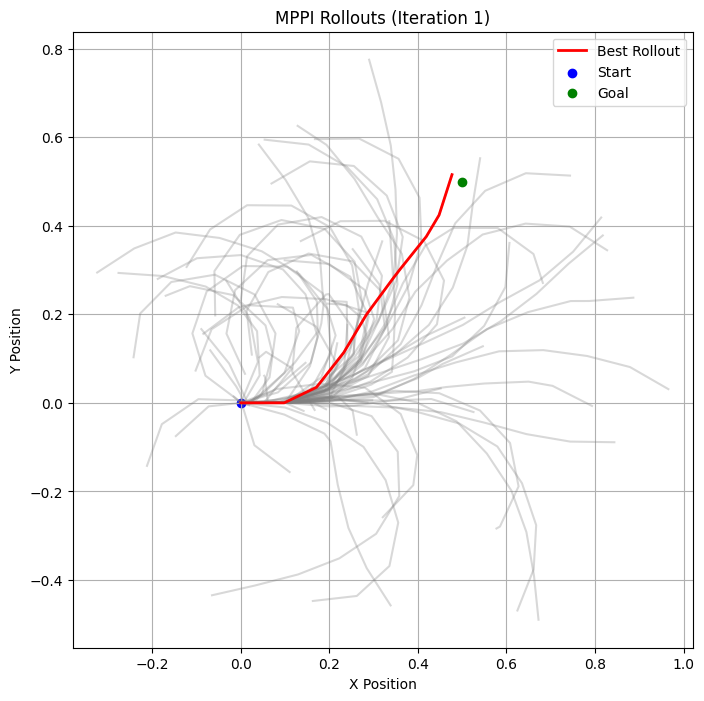

fft_vals: [[ 1.00614556e+02+0.00000000e+00j -1.60260909e+01+1.67000105e+01j
  -7.95992571e+00+1.08149103e+01j -8.68981533e+00+5.74050498e+00j
  -6.48871677e+00+1.50416790e+00j -6.19777666e+00+0.00000000e+00j]
 [ 3.12483866e+01+0.00000000e+00j -3.50187887e+00+9.71369372e+00j
  -4.91041179e+00+1.17307134e+00j -1.13783289e+00+1.50267881e+00j
  -2.21262142e+00-2.71341337e+00j -2.83605470e+00+0.00000000e+00j]
 [-2.34956084e+00+0.00000000e+00j -3.50520214e+00+2.70796480e+00j
  -1.80757214e+00-2.44240031e+00j  2.24681634e+00-2.47361822e+00j
   6.45437725e-01+1.43638110e+00j -2.33061794e-01+0.00000000e+00j]
 [-2.42037414e+01+0.00000000e+00j  2.14677595e+00+2.57694830e+00j
   4.00133709e+00+2.71799336e+00j -2.51223132e+00-1.69768496e+00j
  -5.34241783e-02+1.80524716e-01j  5.85805945e-01+0.00000000e+00j]
 [ 1.99324544e+00+0.00000000e+00j -8.78462379e-01-5.49254463e+00j
   2.26564921e+00-4.58950930e+00j -1.01369665e+00+3.07969528e-01j
   3.46549924e-01-2.98380581e+00j  1.17775536e+00+0.00000000e+

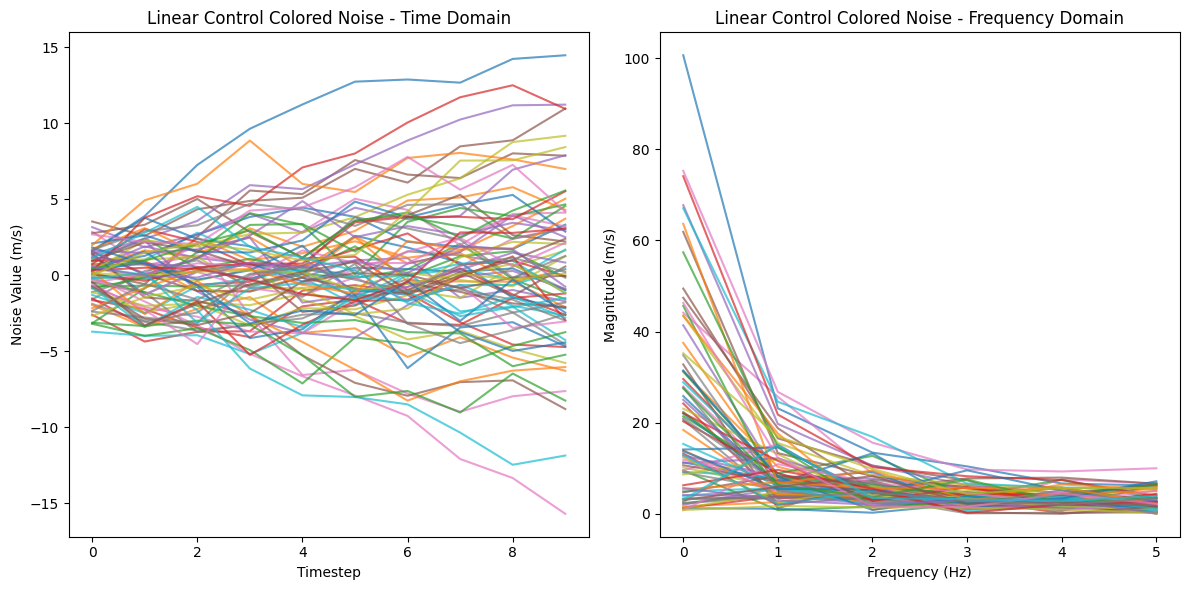

fft_vals: [[ 1.58650231e+01+0.00000000e+00j -3.22557773e-01-2.39009153e-01j
  -1.02640917e+00-1.35419098e+00j -2.05365229e+00-1.75819664e+00j
  -1.21179483e+00-1.97071827e+00j  1.11305087e+00+0.00000000e+00j]
 [ 2.67442300e+01+0.00000000e+00j -1.14609688e+01+6.87988647e+00j
   3.86580910e+00+1.17587679e+00j -4.11365415e+00+1.66405410e+00j
  -2.63590393e+00+3.25850426e-01j -1.62050841e+00+0.00000000e+00j]
 [ 2.78391420e+01+0.00000000e+00j -6.77785239e+00+3.12469026e+00j
  -1.83154135e+00+2.42009021e+00j -5.54158459e-01+3.61931875e+00j
  -9.42165957e-01+2.74547388e+00j -3.59746285e+00+0.00000000e+00j]
 [ 1.48109363e+01+0.00000000e+00j  2.39719586e+00-1.20805073e+00j
   1.27351203e+00+1.08014502e+00j -1.04556685e+00+2.95359878e-01j
   1.71079048e+00-1.05594620e+00j  9.23245800e-01+0.00000000e+00j]
 [ 3.51601543e+01+0.00000000e+00j -8.75232627e+00-2.37768745e+00j
  -3.32279545e+00-2.50148516e-01j  2.36246227e-01-2.25547006e+00j
  -2.00718534e+00-1.04683796e+00j  3.79407691e+00+0.00000000e+

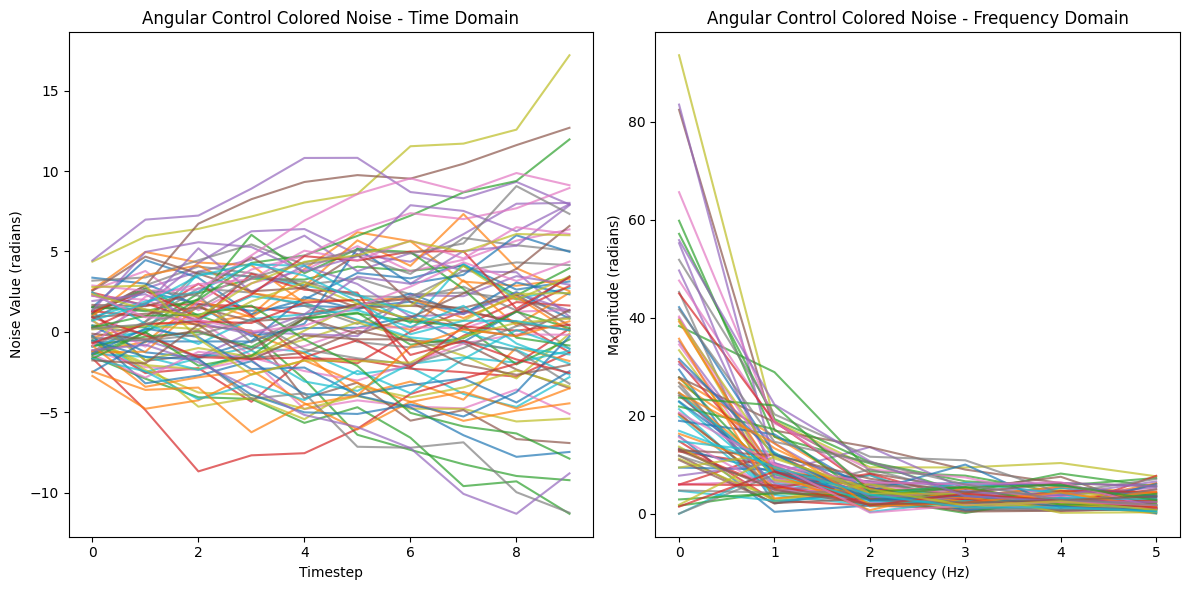

In [ ]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(5926) 
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, .5])

# Instantiate your contoller class
controller = lowFreqMPPI()

# Run your control algorithm f
#or 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_action(initial_state, goal_pos)

In [ ]:
class Map:
    def __init__(self, map_matrix, resolution, origin):
        """
        rolled-my-own map functions to keep it all in-house. 
        this will be used to initialize map
        
        params:
          map_matrix: 2D NumPy array where 0 = free, 1 = occupied
          resolution: size of one cell in world units, i think its 1 meter/cell
          origin: Tuple (x, y) world coord of map (0,0) index
        """
        self.map_matrix = map_matrix
        self.resolution = resolution
        self.origin = origin  # (x_origin, y_origin)

    def indices_to_world_coords(self, row, col):
        """
        convert map indices (with origin at top left) to world coordinates
        (origin at bottom left)

        params:
          row, col: map indices (0-indexed)
        
        returns:
          (x, y): world coordinates
        """
        nrows = self.map_matrix.shape[0]
        x_origin, y_origin = self.origin
        x = x_origin + col * self.resolution
        # (nrows - row - 1) gives how far cell is from bottom
        y = y_origin + (nrows - row - 1) * self.resolution
        return x, y

    
    def world_coords_to_map_indices(self, x, y):
        """
        convert world coords (with origin at bottom left)
        to map indices (with origin at top left)

        params:
          x, y: World coords
        
        returns:
          (row, col): Map indices, 0-indexed
        """
        nrows = self.map_matrix.shape[0]
        x_origin, y_origin = self.origin
        col = int((x - x_origin) / self.resolution)
        # find how many cells above bottom:
        row_from_bottom = int((y - y_origin) / self.resolution)
        # map row (from top) is nrows - 1 - row_from_bottom
        row = nrows - 1 - row_from_bottom
        return row, col


    def check_occupancy(self, i, j):
        """
        check if cell (i, j) is occupied

        params:
          i, j: Indices in map matrix.
          
        returns:
          T if occupied (1) F else
        """
        # first check if in map bounds
        if i < 0 or i >= self.map_matrix.shape[0] or j < 0 or j >= self.map_matrix.shape[1]:
            return True  # out-of-bounds same as obstacle
        return self.map_matrix[i, j] == 1

    def is_collision(self, x, y):
        """
        check for a collision by mapping world coordinates to occupancy grid
        
        params:
          x, y: World coordinates
        
        returns:
          T if corresponding cell=1
        """
        i, j = self.world_coords_to_map_indices(x, y)
        return self.check_occupancy(i, j)


In [ ]:
def plot_maze_with_start_goal(maze, start_world, goal_world):
    """
    plots occupancy grid of maze and overlays start and goal locs,
    displaying map in world coordinates where origin is at bottom left
    
    params:
      maze: instance of Map class
      start_world: Tuple (x, y) start loc in world coordinates
      goal_world: Tuple (x, y) goal loc in world coordinates
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,8))
    
    # determine extent of map for plotting
    origin_x, origin_y = maze.origin
    nrows, ncols = maze.map_matrix.shape
    extent = [origin_x, origin_x + ncols * maze.resolution,
              origin_y, origin_y + nrows * maze.resolution]
    data_to_plot = np.flipud(maze.map_matrix) #flip top to bottom
    plt.imshow(data_to_plot, cmap='gray', extent=extent, origin='lower', alpha=0.5)
    
    # overlay start and goal positions
    plt.scatter(start_world[0], start_world[1], color='blue', marker='o', s=100, label='Start')
    plt.scatter(goal_world[0], goal_world[1], color='green', marker='*', s=150, label='Goal')
    
    plt.title("Maze with Start and Goal")
    plt.xlabel("X (world units)")
    plt.ylabel("Y (world units)")
    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.show()


plot_maze_with_start_goal(maze, start_world, goal_world)

NameError: name 'maze' is not defined

In [ ]:
import numpy as np

csv_path = "../Maps/fig4_maze.csv"
grid = np.loadtxt(csv_path, delimiter=",", skiprows=1)  # Skip header
grid = grid[:, 1:]  # remove index column
grid = 1 - grid  # Invert 1 for 0
grid #loaded and cleaned as above
resolution = 0.1  # 0.1 m per cell
origin = (0.0, 0.0)  # origin

# create instance of Map class
maze = Map(grid, resolution, origin)
# define waypoints indices (0-indexed)
wypts_indices = np.array([[74, 14],
                          [71, 26],
                          [51, 33],
                          [34, 43],
                          [39, 54],
                          [40, 65],
                          [26, 71],
                          [18, 76]])
# convert each (row, col) pair to world coordinates using list comprehension
wypts_world = [maze.indices_to_world_coords(row, col) for row, col in wypts_indices]
wypt_coords = []
print("Waypoints in world coordinates:")
for pt in wypts_world:
    pt = np.round(pt,2)
    wypt_coords.append(pt)
    print(pt)
print(f"wypt_coords: {wypt_coords}")
waypoints = wypt_coords

# for each segment, run MPPI controller
current_state = np.array([waypoints[0][0], waypoints[0][1], 0.0])  # initial state including a heading
for idx in range(len(waypoints) - 1):
    segment_start = waypoints[idx]
    segment_goal = waypoints[idx + 1]
    print(f"Planning from {segment_start} to {segment_goal}")
    # run MPPI until sufficiently close to the segment_goal
    while np.linalg.norm(current_state[:2] - np.array(segment_goal)) > 0.1:
        action = controller.get_action(current_state, np.array(segment_goal), world_map=maze)
        current_state = controller.motion_model.step(current_state, action, controller.dt) # take step


In [ ]:
import re

def excel_cell_to_indices(cell):
    """
    convert an excel cell string
    
    params:
      cell: str eg L75
    
    returns:
      tuple: (row, col) as 0-indexed integers
      - Excel cell references are given with a letter(s) for the column and a number for the row
      - For example, "L75" means the column "L" and row 75
      - converts the column letters using base-26 conversion
        then subtracts one to make the index 0-indexed
      - also subtracts 1 from the row number itself
    """
    # use regular expression to split letters and numbers
    match = re.match(r"^([A-Z]+)(\d+)$", cell)
    if not match:
        raise ValueError("Cell string must like L75")
    
    letters, number = match.groups()
    number = int(number)
    
    # convert letters to column index (1-indexed first)
    col = 0
    for char in letters:
        col = col * 26 + (ord(char) - ord('A') + 1)
    
    # convert to 0-indexed
    col -= 1
    row = number - 1
    return row, col


(26, 71)


In [ ]:
import scipy.signal as sg
import numpy as np
import matplotlib.pyplot as plt

e = np.random.normal(0,1,1000)
E = sg.fft(e)

plt.figure("Bode plot")
plt.subplot(211)
plt.title("Magitude")
plt.plot(abs(E))
plt.subplot(212)
plt.title("Phase")
plt.plot(np.angle(E))
plt.show()

AttributeError: module 'scipy.signal' has no attribute 'fft'

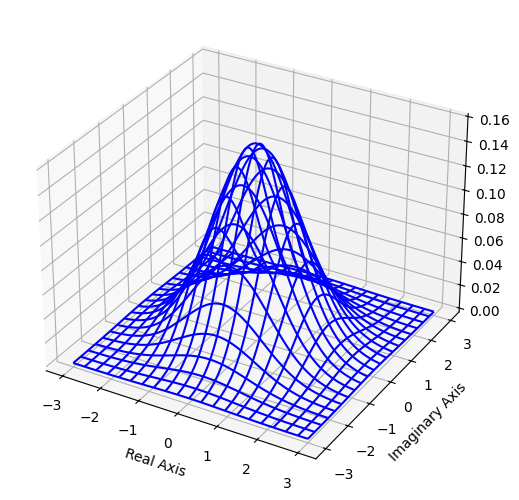

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# define a grid for the real (x) and imaginary (y) axes
x = np.linspace(-3, 3, 100)  # 100 points from -3 to 3 on the real axis
y = np.linspace(-3, 3, 100)  # 100 points from -3 to 3 on the imaginary axis
X, Y = np.meshgrid(x, y)
sigma = 1.0  # std

# compute the 2D Gaussian probability density
Z = (1 / (2 * np.pi * sigma**2)) * np.exp(- (X**2 + Y**2) / (2 * sigma**2))
# create a 3D figure and plot wireframe
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# plot wireframe
ax.plot_wireframe(X, Y, Z, color='b', rstride=5, cstride=5)
# plt.subplots_adjust(left=0.1, right=.9, top=0.9, bottom=0.1)
ax.set_position([0.1, 0.1, 20, 0.8])
ax.set_xlabel("Real Axis") # set axis labels
ax.set_ylabel("Imaginary Axis")
# ax.set_zlabel("Probability Density")

# plt.title("2D Gaussian Distribution")
plt.show()


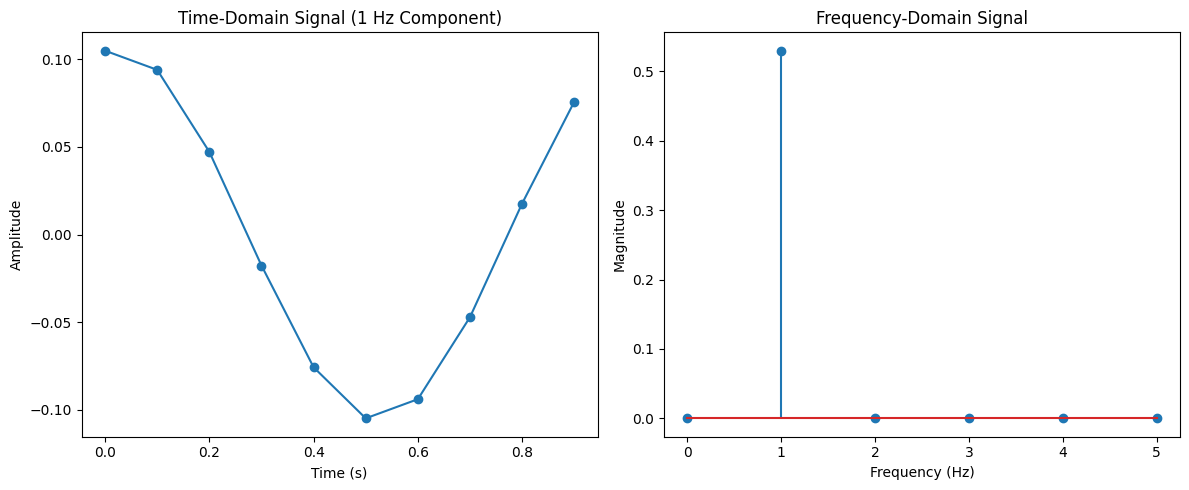

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# parameters for the 1 Hz signal
horizon = 10       # num of time samples
dt = 0.1           # time step in sec
T = horizon * dt   # total duration in sec
n_bins = horizon // 2 + 1  # num of frequency bins from rfft

# create a frequency-domain array with all zeros
F = np.zeros(n_bins, dtype=complex)

# generate a random amplitude and phase for the 1 Hz component
amp = np.random.rand()          # random amp
phase = 2 * np.pi * np.random.rand()  # Random phase in [0, 2π)

# set 1 Hz bin (index 1) to random complex value
F[1] = amp * np.exp(1j * phase)
# compute time-domain signal via inverse real FFT
time_signal = np.fft.irfft(F, n=horizon)
freqs = np.fft.rfftfreq(horizon, d=dt) #freq bins
t = np.arange(horizon) * dt

# create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot time-domain signal
axes[0].plot(t, time_signal, marker='o')
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Time-Domain Signal (1 Hz Component)")

# plot freq-domain signal with stem plot
axes[1].stem(freqs, np.abs(F)) 
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Magnitude")
axes[1].set_title("Frequency-Domain Signal")

plt.tight_layout()
plt.show()
